# Example Comparison Code

In [211]:
import numpy as np
import json
import os
import drjit as dr
import mitsuba as mi
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

mi.set_variant("llvm_ad_rgb_double")

In [212]:
def relative_diff(a, b):
    return (a - b) / b

def simple_diff(a, b):
    return a - b

def abs_diff(a, b):
    return np.abs(a - b)

def sph_to_eucl(theta, phi):
    st, ct = dr.sincos(theta)
    sp, cp = dr.sincos(phi)
    return mi.Vector3f(cp * st, sp * st, ct)

dict_keys(['0.0', '0.017453292519943295', '0.03490658503988659', '0.05235987755982989', '0.06981317007977318', '0.08726646259971647', '0.10471975511965978', '0.12217304763960307', '0.13962634015954636', '0.15707963267948966', '0.17453292519943295', '0.19198621771937624', '0.20943951023931956', '0.22689280275926285', '0.24434609527920614', '0.2617993877991494', '0.2792526803190927', '0.29670597283903605', '0.3141592653589793', '0.33161255787892263', '0.3490658503988659', '0.3665191429188092', '0.3839724354387525', '0.4014257279586958', '0.4188790204786391', '0.4363323129985824', '0.4537856055185257', '0.47123889803846897', '0.4886921905584123', '0.5061454830783556', '0.5235987755982988', '0.5410520681182421', '0.5585053606381855', '0.5759586531581288', '0.5934119456780721', '0.6108652381980153', '0.6283185307179586', '0.6457718232379019', '0.6632251157578453', '0.6806784082777885', '0.6981317007977318', '0.7155849933176751', '0.7330382858376184', '0.7504915783575618', '0.767944870877505

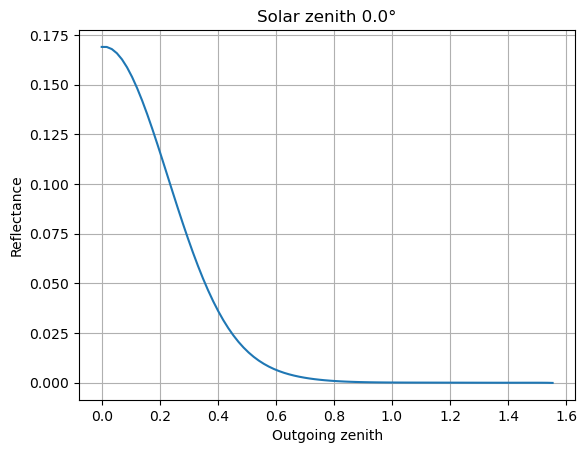

In [213]:
wind_speed = 5
wind_azimuth = 0
data_file = f'data/data_{wind_speed}ms.json'
data = None

# Load data
with open(data_file, 'r') as f:
    data = json.load(f)

'''
Data is stored in the following way:
{
    "solar_zenith_1": {
        "outgoing_zenith_1": "reflectance",
        "outgoing_zenith_2": "reflectance",
        ...
    },
}
'''

print(data.keys())

# Example visual of solar zenith 0.0 with view zenith 0.0
example_solar_zenith = 0.0

example_data = data[str(example_solar_zenith)]
example_outgoing_zeniths = list(map(float, example_data.keys()))
example_outgoing_reflectances = list(map(float, example_data.values()))

# Create a plot
fig, ax = plt.subplots()
im = ax.plot(example_outgoing_zeniths, example_outgoing_reflectances)
ax.set(xlabel='Outgoing zenith', ylabel='Reflectance',
         title=f'Solar zenith {round(np.rad2deg(example_solar_zenith), 2)}°')
ax.grid()
plt.show()


In [214]:
# Create a mitsuba scene to create similar data
# Create a surface interaction
si = dr.zeros(mi.SurfaceInteraction3f)

# Create the solar direction. Data was generated at a solar zenith of 0 radians
si.wi = sph_to_eucl(example_solar_zenith, dr.deg2rad(0))

# Since we want to compare, we create a simple meshgrid of len(outgoing_zeniths) x 1
resolution = len(example_outgoing_zeniths)
zeniths_o, azimuths_o = dr.meshgrid(
    dr.linspace(mi.Float, np.deg2rad(0), np.deg2rad(89), resolution),

    # Data was generated with a viewing azimuth of π radians
    dr.linspace(mi.Float, np.pi, np.pi, 1)
)

# Construct the outgoing directions
wo = sph_to_eucl(zeniths_o, azimuths_o)

In [215]:
# BSDF Construction where we keep the same parameters as the generated data
bsdf = mi.load_dict({
    'type': 'oceanic_legacy',
    'wavelength': 0.5,
    'wind_speed': wind_speed,
    'wind_direction': wind_azimuth,
    'chlorinity': 19,
    'pigmentation': 0.3
})
bsdf

OceanicLegacy[
  wavelength = 0.5
  wind_speed = 5
  wind_direction = 0
  chlorinity = 19
  pigmentation = 0.3
]

2024-07-24 11:45:22 WARN main [oceanic_legacy.cpp:214] Alpha: 0.000003

2024-07-24 11:45:22 WARN main [oceanic_legacy.cpp:215] Lambda: 3.520000

2024-07-24 11:45:22 WARN main [oceanic_legacy.cpp:233] Wavelength: [0.5]

2024-07-24 11:45:22 WARN main [oceanic_legacy.cpp:234] Wind Speed: [5]

2024-07-24 11:45:22 WARN main [oceanic_legacy.cpp:235] Coverage: [0.000851812]

2024-07-24 11:45:22 WARN main [oceanic_legacy.cpp:236] Efficiency: [0.4]

2024-07-24 11:45:22 WARN main [oceanic_legacy.cpp:237] Effective reflectance: [0.32]

2024-07-24 11:45:22 WARN main [oceanic_legacy.cpp:238] Whitecap reflectance: [0.000109032]

2024-07-24 11:45:22 WARN main [oceanic_legacy.cpp:214] Alpha: 0.000003

2024-07-24 11:45:22 WARN main [oceanic_legacy.cpp:215] Lambda: 3.520000

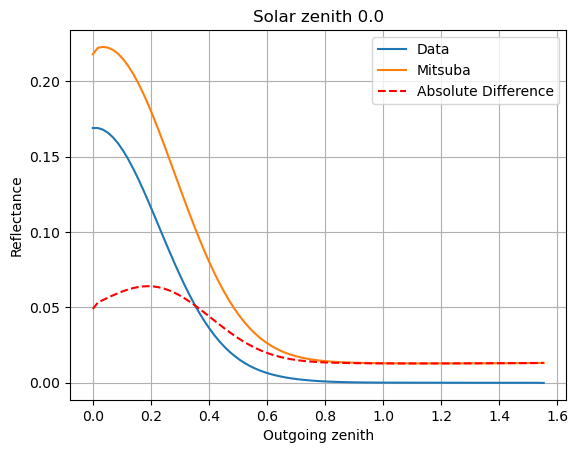

In [216]:
# Evaluate the BSDF
bsdf_values = bsdf.eval(mi.BSDFContext(), si, wo)
bsdf_array = np.array(bsdf_values)

# Extract one channel
bsdf_array = bsdf_array[:, 0]

# Compute the difference between the data and the Mitsuba BSDF
example_outgoing_reflectances = np.array(example_outgoing_reflectances)
reflectance_diff = abs_diff(example_outgoing_reflectances, bsdf_array)

# Plot against the outgoing zeniths
fig, ax = plt.subplots()
im = ax.plot(example_outgoing_zeniths, example_outgoing_reflectances, label='Data')
im = ax.plot(zeniths_o, bsdf_array, label='Mitsuba')
im = ax.plot(zeniths_o, reflectance_diff, label='Absolute Difference', linestyle='--', color='red')
ax.set(xlabel='Outgoing zenith', ylabel='Reflectance',
         title=f'Solar zenith {np.rad2deg(example_solar_zenith)}')
ax.grid()
ax.legend()
plt.show()

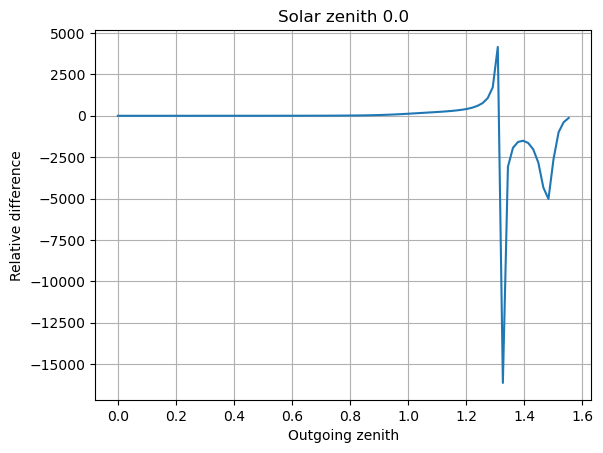

In [217]:
# Relative difference 
relative_diffs = relative_diff(bsdf_array, example_outgoing_reflectances)

fig, ax = plt.subplots()
im = ax.plot(zeniths_o, relative_diffs)
ax.set(xlabel='Outgoing zenith', ylabel='Relative difference',
         title=f'Solar zenith {np.rad2deg(example_solar_zenith)}')
ax.grid()
plt.show()